# Time Series Modeling: Spain Energy Data

## Prepare Notebook

**Read in libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

**Set Notebook Preferences**

In [2]:
#Set Pandas preferenes
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

#Set style for matplotlib and fontdict for plots
plt.style.use('seaborn')
title_dict= {'fontsize':18,
            'style': 'italic',
            'fontweight': 'semibold'}

label_dict= {'fontsize':14,
             'fontweight': 'semibold'}

#Surpress annoying warnings
import warnings
warnings.filterwarnings('ignore')

#Set path to write visuals
eda_path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Visualizations\03_Modeling'

#Set path to data
path = r'\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Data\03_Processed_Data'

**Read in data**

In [3]:
#Read in training and test data
X_train = pd.read_csv(path + '/2020_0624_Training_Data.csv', index_col=0)
X_test = pd.read_csv(path + '/2020_0624_Test_Data.csv', index_col=0)

#Read in price and load forecasts data
data_forecasts = pd.read_csv(path + '/2020_710_tso_predictions.csv', index_col=0)

**Preview Data**

In [4]:
#Display data
print('Training data shape:', X_train.shape)
display(X_train.head())

#Display data
print('\nTest data shape:',X_test.shape)
display(X_test.head())

#Display data
print('\nTest data shape:',data_forecasts.shape)
display(data_forecasts.head())

Training data shape: (29789, 44)


,generation_fossil_gas,generation_fossil_gas_stationary,generation_fossil_hard_coal,generation_fossil_hard_coal_stationary,generation_hydro_pumped_storage_consumption,generation_hydro_pumped_storage_consumption_stationary,price_actual,price_actual_season,price_actual_stationary,price_actual_trend,total_load_actual,total_load_actual_season,total_load_actual_stationary,total_load_actual_trend,is_weekend,holiday,price_actual_lag_1,price_actual_lag_2,price_actual_lag_3,price_actual_lag_4,price_actual_lag_5,price_actual_lag_6,price_actual_lag_7,price_actual_lag_8,price_actual_lag_9,price_actual_lag_10,price_actual_lag_11,price_actual_lag_12,price_actual_lag_13,price_actual_lag_14,price_actual_lag_15,price_actual_lag_16,price_actual_lag_17,price_actual_lag_18,price_actual_lag_19,price_actual_lag_20,price_actual_lag_21,price_actual_lag_22,price_actual_lag_23,price_actual_lag_24,year_encoded,month_encoded,weekday_encoded,hour_encoded
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 12:00:00,3784.0,-821.652818,4220.0,-134.521023,972.0,131.336181,60.12,3.750959,-5.750750,62.119792,24133.0,2352.743184,-2151.597351,23931.854167,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006679,0.006571,-0.012041,1.173354
2015-01-01 13:00:00,3754.0,-788.106788,4404.0,159.169985,922.0,81.075629,62.05,3.292118,-3.198368,61.956250,24713.0,2856.356263,-2121.835430,23978.479167,False,True,-5.750750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006679,0.006571,-0.012041,1.005509
2015-01-01 14:00:00,3779.0,-633.241441,4256.0,159.104975,941.0,30.936512,62.06,2.675646,-2.233563,61.617917,24672.0,3004.248460,-2332.248460,24000.000000,False,True,-3.198368,-5.750750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006679,0.006571,-0.012041,-0.006046
2015-01-01 15:00:00,3708.0,-568.192702,4038.0,101.672295,1069.0,50.314849,59.76,1.874951,-3.437243,61.322292,23528.0,2840.023129,-3348.148129,24036.125000,False,True,-2.233563,-3.198368,-5.750750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006679,0.006571,-0.012041,-1.853876
2015-01-01 16:00:00,3813.0,-363.724387,4191.0,415.279699,970.0,-168.099337,61.18,1.011884,-1.000426,61.168542,23118.0,2473.497661,-3455.914328,24100.416667,False,True,-3.437243,-2.233563,-3.198368,-5.75075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006679,0.006571,-0.012041,-2.547201



Test data shape: (5257, 44)


,generation_fossil_gas,generation_fossil_gas_stationary,generation_fossil_hard_coal,generation_fossil_hard_coal_stationary,generation_hydro_pumped_storage_consumption,generation_hydro_pumped_storage_consumption_stationary,price_actual,price_actual_season,price_actual_stationary,price_actual_trend,total_load_actual,total_load_actual_season,total_load_actual_stationary,total_load_actual_trend,is_weekend,holiday,price_actual_lag_1,price_actual_lag_2,price_actual_lag_3,price_actual_lag_4,price_actual_lag_5,price_actual_lag_6,price_actual_lag_7,price_actual_lag_8,price_actual_lag_9,price_actual_lag_10,price_actual_lag_11,price_actual_lag_12,price_actual_lag_13,price_actual_lag_14,price_actual_lag_15,price_actual_lag_16,price_actual_lag_17,price_actual_lag_18,price_actual_lag_19,price_actual_lag_20,price_actual_lag_21,price_actual_lag_22,price_actual_lag_23,price_actual_lag_24,year_encoded,month_encoded,weekday_encoded,hour_encoded
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-26 14:00:00,6048.0,24.309123,4527.0,-24.743331,194.0,129.695125,66.61,0.535144,-0.877644,66.952500,27714.0,2141.914399,582.731434,24989.354167,True,False,1.307907,0.785257,0.276229,-0.425243,-1.333459,-1.017779,-4.436287,-1.182674,2.641011,4.741973,6.384998,6.182495,7.719990,6.724111,4.979401,3.747898,2.075793,-2.983813,-5.369979,-6.251566,-7.327623,-3.964918,-1.773162,-0.300561,-0.004365,-0.010393,-0.124589,-0.006046
2018-05-26 15:00:00,5663.0,-418.343756,4094.0,-439.425570,194.0,129.664444,60.59,0.799412,-7.262954,67.053542,26342.0,1921.311927,-484.686927,24905.375000,True,False,-0.877644,1.307907,0.785257,0.276229,-0.425243,-1.333459,-1.017779,-4.436287,-1.182674,2.641011,4.741973,6.384998,6.182495,7.719990,6.724111,4.979401,3.747898,2.075793,-2.983813,-5.369979,-6.251566,-7.327623,-3.964918,-1.773162,-0.004365,-0.010393,-0.124589,-1.853876
2018-05-26 16:00:00,5466.0,-730.323850,3676.0,-872.340738,463.0,447.250389,56.99,2.340335,-12.490127,67.139792,25461.0,1993.187712,-1355.937712,24823.750000,True,False,-7.262954,-0.877644,1.307907,0.785257,0.276229,-0.425243,-1.333459,-1.017779,-4.436287,-1.182674,2.641011,4.741973,6.384998,6.182495,7.719990,6.724111,4.979401,3.747898,2.075793,-2.983813,-5.369979,-6.251566,-7.327623,-3.964918,-0.004365,-0.010393,-0.124589,-2.547201
2018-05-26 17:00:00,5289.0,-1068.997594,3610.0,-968.334274,492.0,552.085877,56.71,4.743248,-15.208039,67.174792,25063.0,2323.286685,-2007.453351,24747.166667,True,False,-12.490127,-7.262954,-0.877644,1.307907,0.785257,0.276229,-0.425243,-1.333459,-1.017779,-4.436287,-1.182674,2.641011,4.741973,6.384998,6.182495,7.719990,6.724111,4.979401,3.747898,2.075793,-2.983813,-5.369979,-6.251566,-7.327623,-0.004365,-0.010393,-0.124589,-1.550646
2018-05-26 18:00:00,5351.0,-1106.621481,3880.0,-712.198986,280.0,402.886319,59.06,5.793649,-13.923441,67.189792,24944.0,2489.289653,-2213.977153,24668.687500,True,False,-15.208039,-12.490127,-7.262954,-0.877644,1.307907,0.785257,0.276229,-0.425243,-1.333459,-1.017779,-4.436287,-1.182674,2.641011,4.741973,6.384998,6.182495,7.719990,6.724111,4.979401,3.747898,2.075793,-2.983813,-5.369979,-6.251566,-0.004365,-0.010393,-0.124589,0.833284



Test data shape: (5257, 2)


,price_day_ahead,total_load_forecast
date_time,,
2018-05-26 14:00:00,60.71,27692.0
2018-05-26 15:00:00,55.00,26391.0
2018-05-26 16:00:00,51.20,25553.0
2018-05-26 17:00:00,51.20,25247.0
2018-05-26 18:00:00,53.08,25012.0


# Modeling

## Base Model - TSO Predictions

**Prepare data**

In [5]:
#Get TSO forecasts for test data
tso_predictions = data_forecasts['price_day_ahead']
actual = X_test['price_actual']

**Evaluate TSO Predictions**

TSO Forecasts Performance Metrics
MAE:8.590249191554118
MAPE:12.35765486690077%
MSE:142.90224192505232
RMSE:11.95417257383598


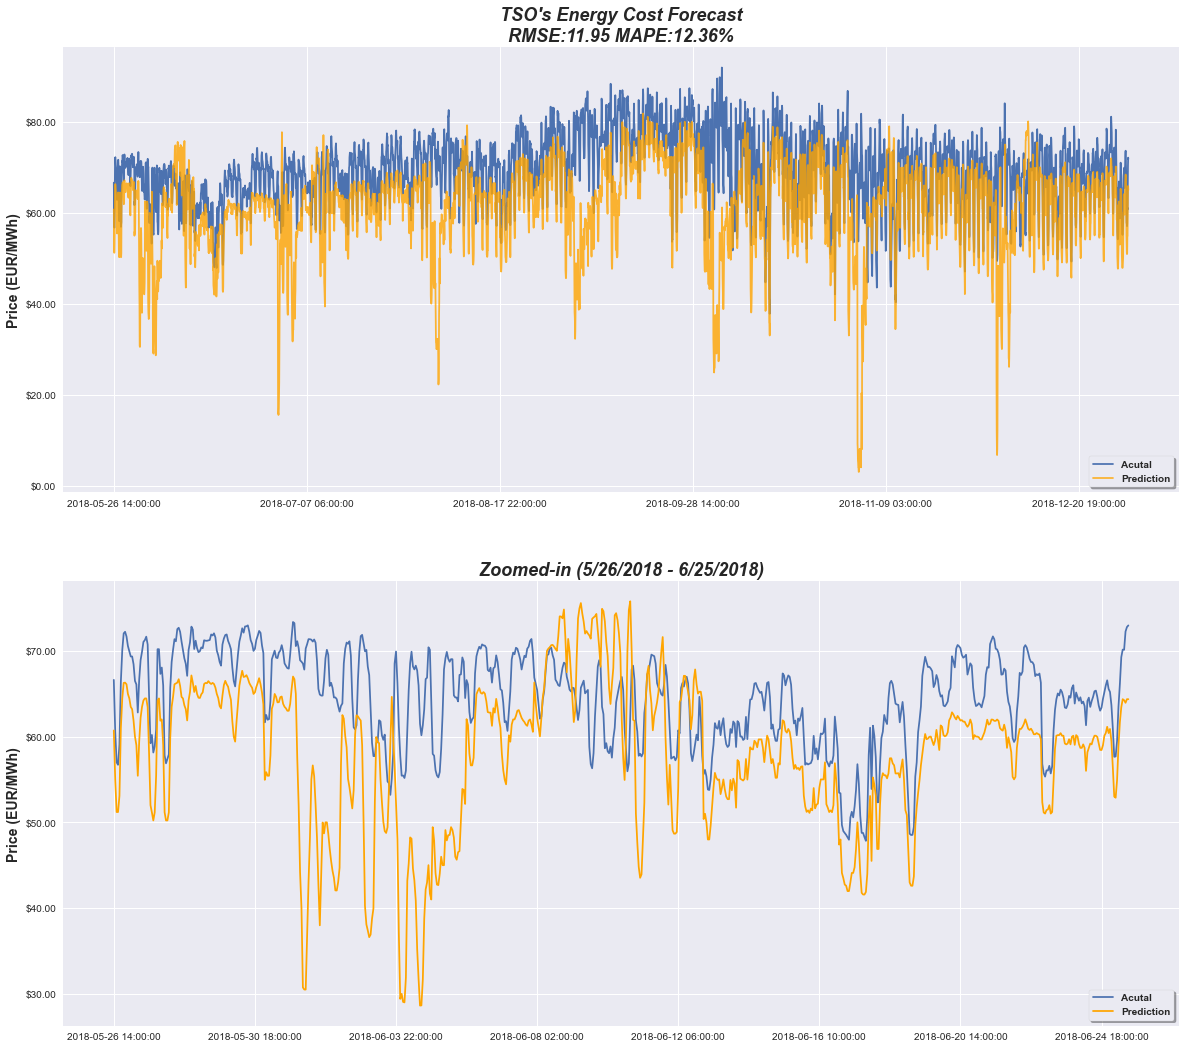

In [6]:
#Read in model_performance to capture metrics and timeseries_plot to plot timeseries
from TimeSeriesStats import model_performance
from TimeseriesPlotter import timeseries_plot

#Evaluate price preditions
metrics = model_performance(tso_predictions.values, actual.values, 'TSO Forecasts')

#Create fig
f, ax = plt.subplots(2,1,figsize = (20,18))

#Plot original data
timeseries_plot(actual, ax = ax[0])
timeseries_plot(tso_predictions,title='TSO\'s Energy Cost Forecast\nRMSE:{} MAPE:{}%'.format(round(metrics['RMSE'],2),round(metrics['MAPE'],2)), 
                 ylabel='Price (EUR/MWh)',label_dict=label_dict,
                title_dict=title_dict, color = 'orange', ax = ax[0], alpha = .8)

#Plot zoomed data
timeseries_plot(actual[:24*30], ax = ax[1])
timeseries_plot(tso_predictions[:24*30],title='Zoomed-in (5/26/2018 - 6/25/2018)', title_dict=title_dict, ylabel='Price (EUR/MWh)',label_dict=label_dict,
                 color = 'orange', ax = ax[1])

###Set plot aesthetics###
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))));
ax[0].legend(['Acutal', 'Prediction'],prop=dict(weight='bold'),fontsize = 14, shadow = True, frameon=True, loc = 'lower right')

ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))));
ax[1].legend(['Acutal', 'Prediction'], prop=dict(weight='bold'),shadow =True,frameon=True, fontsize = 14,loc = 'lower right');

#Write visual to path
plt.savefig(eda_path + '/TSO_Cost_Predictions.png',bbox_inches='tight')

# Multivariate Analysis

**Prepare Data**

In [7]:
#Subset stationary features for multivariate analysis and scale
X_train_multivariate = X_train.filter(regex='stationary')

#Check
print('Multivariate training data shape:{}'.format(X_train_multivariate.shape))

Multivariate training data shape:(29789, 5)


### Vector Autoregression

In [8]:
#Read in and init VARMAX
from statsmodels.tsa.api import VAR

#Init VAR model
model = VAR(X_train_multivariate)

#Find optimal value for P
display(model.select_order(maxlags=24).summary())

#Fit model with maxlags = 24
model_fitted = model.fit(24)

C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,56.07,56.07,2.236e+24,56.07
1,50.20,50.21,6.360e+21,50.21
2,49.04,49.05,1.978e+21,49.04
3,48.99,49.02,1.894e+21,49.00
4,48.93,48.96,1.780e+21,48.94
5,48.90,48.94,1.724e+21,48.91
6,48.87,48.92,1.680e+21,48.89
7,48.85,48.90,1.643e+21,48.87
8,48.82,48.88,1.598e+21,48.84
9,48.79,48.86,1.554e+21,48.82


**Check for serial correlation**

In [9]:
#Import durbin_watson
from statsmodels.stats.stattools import durbin_watson

#Init durbin_watson and get serial correlation results
serial_corr = durbin_watson(model_fitted.resid)

#View results
for col,value in zip(X_train_multivariate.columns, serial_corr):
    print(col, 'DW Statistic:', round(value,3))

generation_fossil_gas_stationary DW Statistic: 2.021
generation_fossil_hard_coal_stationary DW Statistic: 1.995
generation_hydro_pumped_storage_consumption_stationary DW Statistic: 2.015
price_actual_stationary DW Statistic: 2.02
total_load_actual_stationary DW Statistic: 2.04


**Forecast Predictions w/ VAR**

In [10]:
#Prepare input data, making sure to invert time series
lag_order = model_fitted.k_ar
var_input_data = X_train_multivariate[-lag_order:].values

#Make forecast
forecast = model_fitted.forecast(var_input_data, steps = len(X_test))

**Convert forecasts and evaluate performance on target**

In [11]:
#Create a dataframe of forecast values
var_forecasts = pd.DataFrame(forecast, index=X_test.index, columns=X_train_multivariate.columns)

#Subset trend and season values from X_test
trend_season = X_test.filter(regex='season|trend')

#Concatenate and sort columns alphabetically
var_forecasts = pd.concat([var_forecasts,trend_season], axis = 1)
var_forecasts = var_forecasts.reindex(sorted(var_forecasts.columns), axis = 1)

#Convert predictions on price_actual and total_load_Actual
var_forecasts['price_actual_predictions'] = var_forecasts['price_actual_stationary'] + var_forecasts['price_actual_season'] + var_forecasts['price_actual_trend']
var_forecasts['total_load_actual_predictions'] = var_forecasts['total_load_actual_stationary'] + var_forecasts['total_load_actual_season'] + var_forecasts['total_load_actual_trend']

#Check
display(var_forecasts.head())

,generation_fossil_gas_stationary,generation_fossil_hard_coal_stationary,generation_hydro_pumped_storage_consumption_stationary,price_actual_season,price_actual_stationary,price_actual_trend,total_load_actual_season,total_load_actual_stationary,total_load_actual_trend,price_actual_predictions,total_load_actual_predictions
date_time,,,,,,,,,,,
2018-05-26 14:00:00,-129.228745,4.812374,145.799430,0.535144,0.318547,66.952500,2141.914399,852.693296,24989.354167,67.806191,27983.961862
2018-05-26 15:00:00,-211.953160,-80.643442,207.958736,0.799412,-1.952381,67.053542,1921.311927,521.474252,24905.375000,65.900573,27348.161179
2018-05-26 16:00:00,-219.275990,-114.083722,304.135531,2.340335,-4.388437,67.139792,1993.187712,-35.160998,24823.750000,65.091690,26781.776714
2018-05-26 17:00:00,-277.126660,-165.178367,334.073717,4.743248,-5.953971,67.174792,2323.286685,-775.352274,24747.166667,65.964069,26295.101077
2018-05-26 18:00:00,-298.615695,-199.575195,300.449019,5.793649,-6.359934,67.189792,2489.289653,-1307.041700,24668.687500,66.623506,25850.935453


### Evaluate Price Forecasts

In [12]:
#Evaluate VAR performance on price_actual predictions
var_metrics = model_performance(var_forecasts['price_actual_predictions'].values, X_test['price_actual'].values, 'VAR')

VAR Performance Metrics
MAE:4.265074643430418
MAPE:6.495307878186127%
MSE:31.180247664444657
RMSE:5.583927619914558


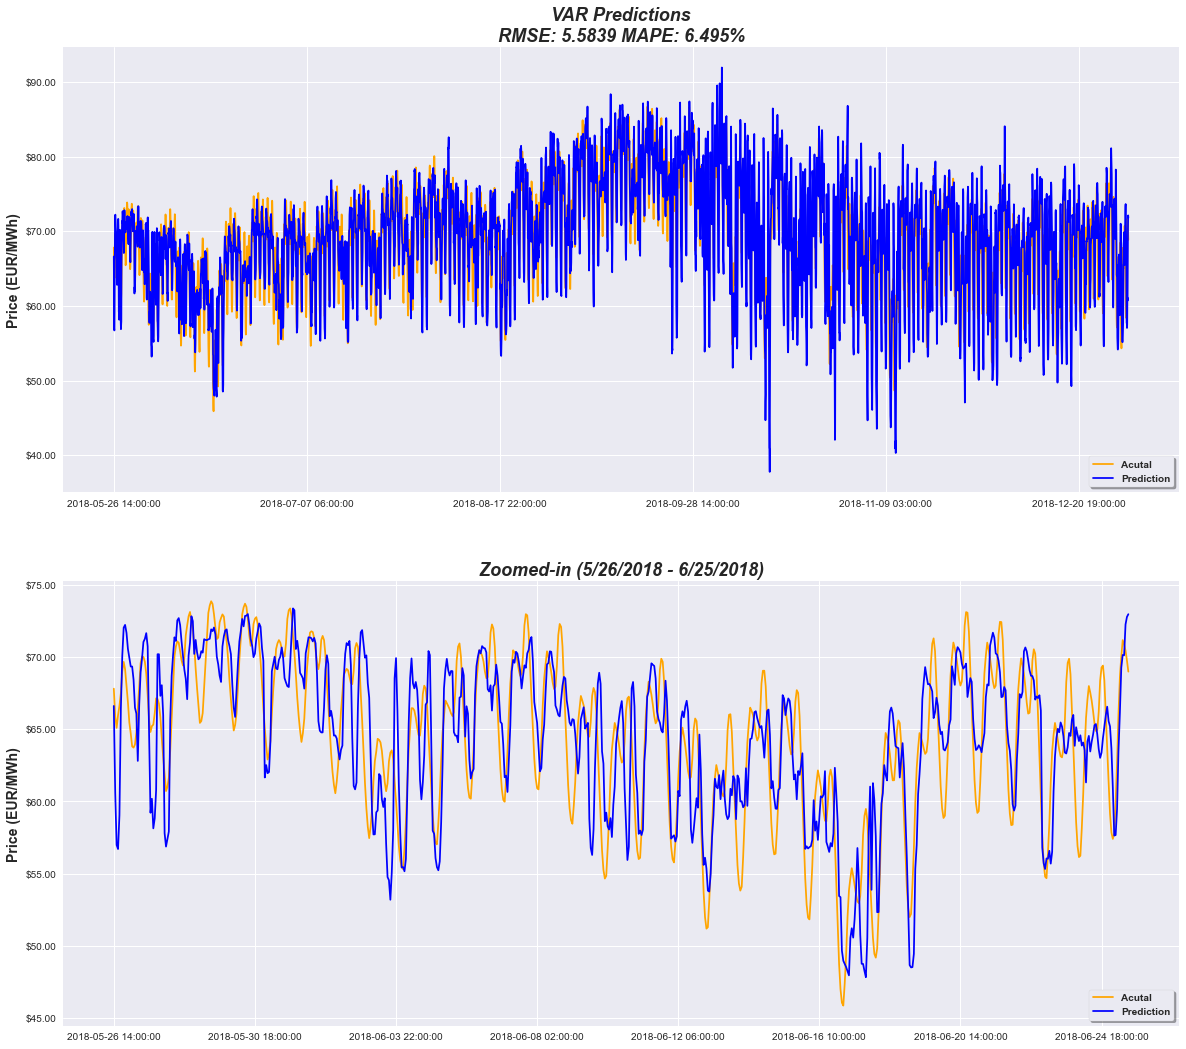

In [13]:
#Create figure
f, ax = plt.subplots(2,1,figsize = (20,18))

#Plot predictions
timeseries_plot(var_forecasts['price_actual_predictions'], ax = ax[0], color = 'orange')
timeseries_plot(X_test['price_actual'],title ='VAR Predictions\nRMSE: {} MAPE: {}%'.format(round(var_metrics['RMSE'],4),round(var_metrics['MAPE'],3)), title_dict=title_dict,
                ax = ax[0], color = 'blue',ylabel='Price (EUR/MWh)',label_dict=label_dict)

timeseries_plot(var_forecasts['price_actual_predictions'][:24*30], ax = ax[1], color = 'orange')
timeseries_plot(X_test['price_actual'][:24*30], ax = ax[1], color = 'blue',title='Zoomed-in (5/26/2018 - 6/25/2018)', title_dict=title_dict, ylabel='Price (EUR/MWh)',label_dict=label_dict,)

ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))))
ax[0].legend(['Acutal', 'Prediction'], prop=dict(weight='bold'),shadow =True,frameon=True, fontsize = 14,loc = 'lower right')

ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))))
ax[1].legend(['Acutal', 'Prediction'], prop=dict(weight='bold'),shadow =True,frameon=True, fontsize = 14,loc = 'lower right');

### Multivariate XGBoost

**Prepare data**

In [14]:
###Prepare training data###
#Subset colds
X_train_boost = X_train.filter(regex = 'stationary|lag|encoded|weekend|holiday')

#Drop NA
X_train_boost.dropna(inplace = True, axis = 0)

#Set target for multivariate xgboost and drop from X_train_boost
y_train_boost = X_train_boost['price_actual_stationary']
X_train_boost.drop(['price_actual_stationary'], axis = 1, inplace = True)

#check
print('Shape of Xgboost training data:{}\nShape of Xgboost training labels data:{}'.format(X_train_boost.shape,y_train_boost.shape))

Shape of Xgboost training data:(29765, 34)
Shape of Xgboost training labels data:(29765,)


In [15]:
###Prepare Test data###
#Subset colds
X_test_boost = X_test.filter(regex = 'stationary|lag|encoded|weekend|holiday')

#Drop NA
X_test_boost.dropna(inplace = True, axis = 0)

#Set target for multivariate xgboost and drop from X_train_boost
y_test_boost = X_test_boost['price_actual_stationary']
X_test_boost.drop(['price_actual_stationary'], axis = 1, inplace = True)

#check
print('Shape of Xgboost training data:{}\nShape of Xgboost training labels data:{}'.format(X_test_boost.shape,y_test_boost.shape))

Shape of Xgboost training data:(5257, 34)
Shape of Xgboost training labels data:(5257,)


**Build Model**

In [16]:
#Import libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [17]:
# #Init scaler
# scaler = MinMaxScaler()

# #Init XGBRegressor
# xgbr = xgb.XGBRegressor(random_state = 24)

# #Init pipeline
# pipe = Pipeline([('scaler',scaler),
#                 ('model', xgbr)])

# #Set parameters for XGBRegressor to test over
# params = {'model__n_jobs':[-1],
#          'model__max_depth':[6,7,8],
#          'model__n_estimators':[200,300,400],
#           'model__learning_rate': [.01,.1]
#          }
          
# #Build Regressor
# regressor = GridSearchCV(pipe, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error', cv = 3)

# #Fit to training data
# regressor.fit(X_train_boost,y_train_boost)

In [18]:
# #Get results
# print('Best MAE:{}\nBest estimator:\n{}'.format((-1*regressor.best_score_),regressor.best_estimator_))

# #Save pipeline
# import joblib
# joblib.dump(regressor.best_estimator_, 'xgbregressor.pkl', compress = 1)

In [19]:
import joblib
#Load best regressor
regressor = joblib.load('xgbregressor.pkl')

In [20]:
#Fit to test data
predictions = regressor.predict(X_test_boost)

#Store predictions in a data frame. Add seasonality and trend to predictions
xgbr_predictions = pd.DataFrame(predictions, index=y_test_boost.index)
xgbr_predictions.columns = ['raw_predictions']

xgbr_predictions['actual'], xgbr_predictions['price_season'], xgbr_predictions['price_trend']=[X_test['price_actual'],X_test['price_actual_season'], X_test['price_actual_trend']]

xgbr_predictions['corrected_predictions'] = xgbr_predictions['raw_predictions'] + xgbr_predictions['price_season'] +xgbr_predictions['price_trend']

#check
display(xgbr_predictions.head())

,raw_predictions,actual,price_season,price_trend,corrected_predictions
date_time,,,,,
2018-05-26 14:00:00,0.795956,66.61,0.535144,66.952500,68.283601
2018-05-26 15:00:00,-3.524338,60.59,0.799412,67.053542,64.328616
2018-05-26 16:00:00,-9.302688,56.99,2.340335,67.139792,60.177439
2018-05-26 17:00:00,-12.171290,56.71,4.743248,67.174792,59.746749
2018-05-26 18:00:00,-13.699849,59.06,5.793649,67.189792,59.283591


Multivariate XGBR Performance Metrics
MAE:1.2726950192694229
MAPE:1.8877178646878636%
MSE:2.9447896094448476
RMSE:1.7160389300493295


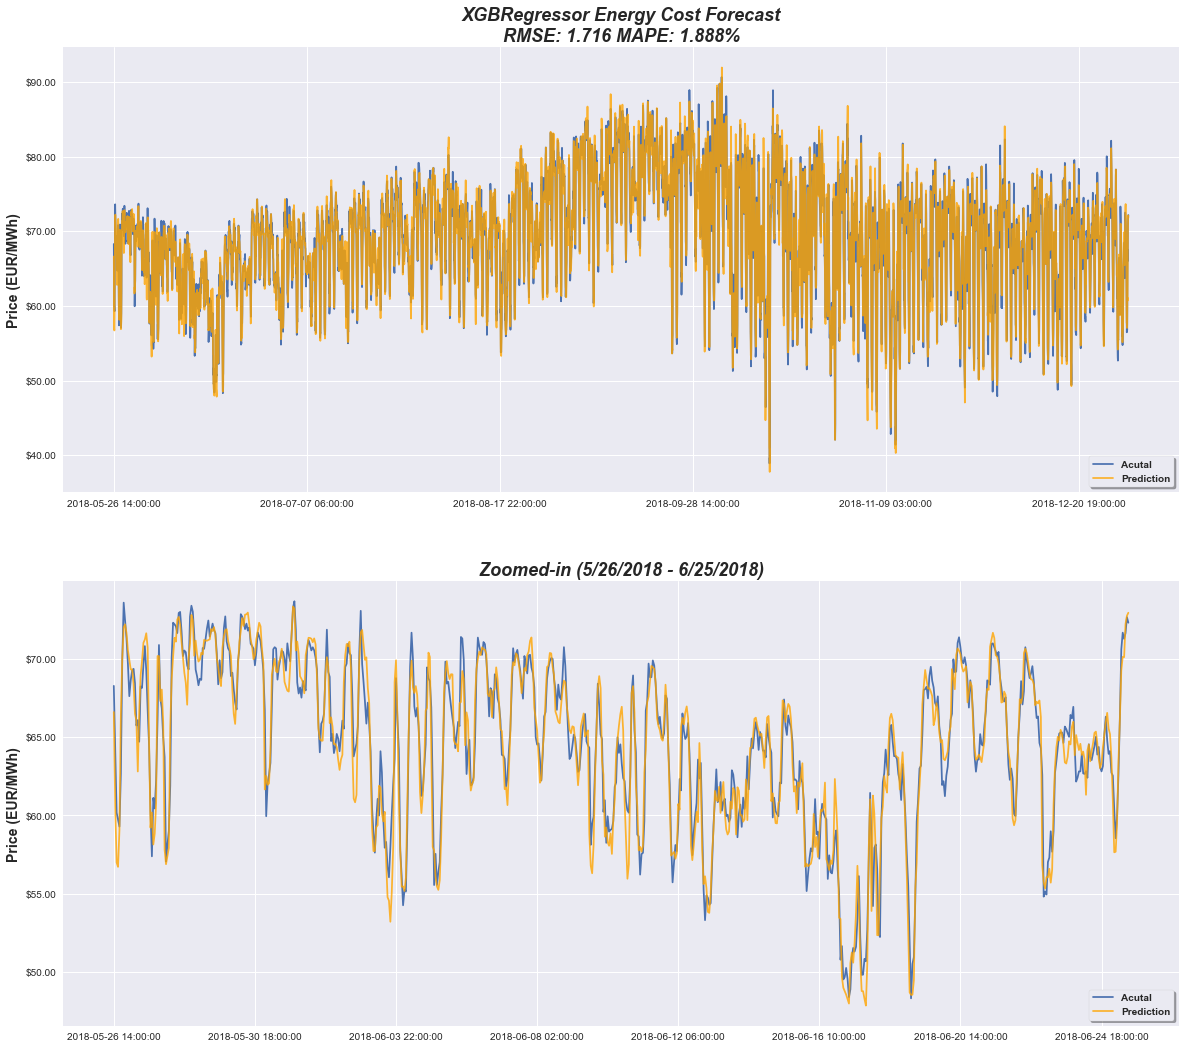

In [21]:
#Get metrics
xgbr_metrics = model_performance(xgbr_predictions.corrected_predictions.values, xgbr_predictions.actual.values, 'Multivariate XGBR')

#Create figure
f, ax = plt.subplots(2,1,figsize = (20,18))
timeseries_plot(xgbr_predictions.corrected_predictions, ax=ax[0])
timeseries_plot(xgbr_predictions.actual, ax=ax[0],
                title ='XGBRegressor Energy Cost Forecast\nRMSE: {} MAPE: {}%'.format(round(xgbr_metrics['RMSE'],4),round(xgbr_metrics['MAPE'],3)), title_dict=title_dict,
                 ylabel='Price (EUR/MWh)',label_dict=label_dict,color = 'orange',alpha = .8)
                
timeseries_plot(xgbr_predictions.corrected_predictions[:24*30], ax=ax[1])
timeseries_plot(xgbr_predictions.actual[:24*30], ax=ax[1],title='Zoomed-in (5/26/2018 - 6/25/2018)', 
                color = 'orange',alpha = .8, title_dict=title_dict, ylabel='Price (EUR/MWh)',label_dict=label_dict)

ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))))
ax[0].legend(['Acutal', 'Prediction'], prop=dict(weight='bold'),shadow =True,frameon=True, fontsize = 14,loc = 'lower right')

ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))))
ax[1].legend(['Acutal', 'Prediction'], prop=dict(weight='bold'),shadow =True,frameon=True, fontsize = 14,loc = 'lower right');

#Write visual to path
plt.savefig(eda_path + '/XGBR_Cost_Predictions.png',bbox_inches='tight')

**Visualize Feature Importances on Training Data**

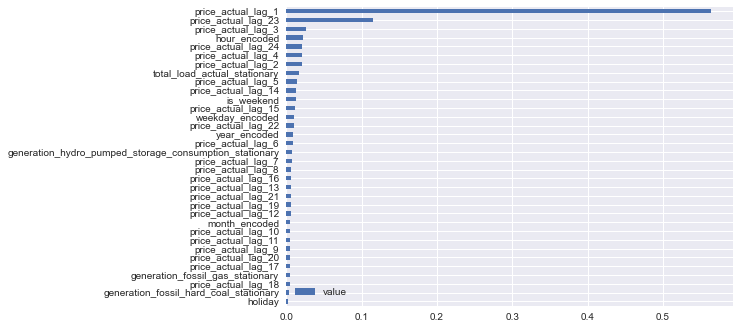

In [22]:
#Get feature importances from model
values = regressor.steps[1][1].feature_importances_

#Store feature importances in a data frame
feature_importance = pd.DataFrame(values, index=X_test_boost.columns)
feature_importance.columns = ['value']
feature_importance.sort_values(by='value', ascending = 'False', inplace = True)

feature_importance.plot(kind = 'barh')

# Cost Evaluation

**Prepare data**

In [37]:
#Concat predictions and actual values
cost_evaluation = pd.concat([tso_predictions,xgbr_predictions.corrected_predictions,actual],axis = 1)
cost_evaluation.columns = ['tso_predictions','xgbr_predictions','actual']

#Split date_time into hour and date
cost_evaluation.reset_index(inplace = True)
cost_evaluation[['date','hour']] = cost_evaluation['date_time'].str.split(' ', expand = True)
cost_evaluation.drop('date_time', axis = 1, inplace = True)

#Calculate diff of predictions and actual
tso_diff, xgbr_diff = cost_evaluation['actual'] - cost_evaluation['tso_predictions'],cost_evaluation['actual'] - cost_evaluation['xgbr_predictions']
cost_evaluation['tso_diff'] = tso_diff
cost_evaluation['xgbr_diff'] =  xgbr_diff
cost_evaluation = cost_evaluation.reindex(sorted(cost_evaluation.columns), axis=1)

#Check
display(cost_evaluation.head())

,actual,date,hour,tso_diff,tso_predictions,xgbr_diff,xgbr_predictions
0,66.61,2018-05-26,14:00:00,5.90,60.71,-1.673601,68.283601
1,60.59,2018-05-26,15:00:00,5.59,55.00,-3.738616,64.328616
2,56.99,2018-05-26,16:00:00,5.79,51.20,-3.187439,60.177439
3,56.71,2018-05-26,17:00:00,5.51,51.20,-3.036749,59.746749
4,59.06,2018-05-26,18:00:00,5.98,53.08,-0.223591,59.283591


In [38]:
print('TSO Predictions were off by ${}\nXGBR Predictions off by ${}'.format(round(np.sum(cost_evaluation.tso_diff),2),round(np.sum(cost_evaluation.xgbr_diff),2)))

TSO Predictions were off by $41595.38
XGBR Predictions off by $134.0


In [42]:
#Daily Error
print(np.mean(cost_evaluation.groupby('date')['tso_diff'].mean()))

print(np.mean(cost_evaluation.groupby('date')['xgbr_diff'].mean()))

7.902927777777777
0.020737358471852003


In [44]:
#hourly
print(np.mean(cost_evaluation.groupby('hour')['tso_diff'].mean()))
print(np.mean(cost_evaluation.groupby('hour')['xgbr_diff'].mean()))

5.570833333333334
0.02326075706864117
